In [1]:
import os
import pandas as pd
import censusgeocode as cg
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as sp
import ipyparallel as ipp

In [2]:
# where are we?
start = os.getcwd()
os.getcwd()

'C:\\Users\\etos\\Downloads\\thesis - Copy'

In [3]:
with open("start_here_clean.pkl","rb") as f:
    wdf = pd.read_pickle(f)

In [4]:
def naive(one,two):
    
    # instantiate variables
    temp = []
    output = []
    
    # multiply probabilities
    for i,j in zip(one,two):
        temp.append(i*j)
        
    # find the marginal and normalize
    total = sum(temp)
    
    for i in temp:
        output.append(i/total)
        
    return output
        
    
# complex variant of the preceding, where the multi-class
# is treated differently than the single class as it is the catch all.
def non_naive(one,two):
    
    # instantiate variables
    output = []
    
    # multiply non-multi-class-probabilities
    for i,j in zip(one[:-1],two[:-1]):
        output.append(i*j)
        
    # find the multi-class remainder.
    output.append(1-sum(output))
    
    return output
    
    

In [5]:
%%time

home_ownership = [.725,.419, .57, .57, .46,.57]
rent_pop = 1 - np.array(home_ownership)

Wall time: 0 ns


In [6]:
wdf["loc_scale"] = wdf.apply(lambda x: naive(rent_pop,x.loc_scale),axis = 1)

# Use the inherent distribution

In [7]:
%%time

wdf["naive"] = wdf.apply(lambda x: naive(x.sur,x.loc_scale),axis = 1)

Wall time: 2.93 s


In [8]:
t2df = wdf.copy()

In [9]:
boot_nums = t2df.loc[:,["loc_scale","blk_row_num","naive","plaintiff"]]

In [10]:
df = boot_nums.copy()
rename = dict(zip(df.columns,[0,1,2]))
df.rename(columns=rename,inplace = True)

# First real boot strap

In [11]:
def boot_strap_local(n = 1000):
    import pandas as pd
    import numpy as np
    df = boot_nums.copy()
    rename = dict(zip(df.columns,[0,1,2]))
    df.rename(columns=rename,inplace = True)

    boot = []


    for i in range(n):
        boot_obs = []

        # generate bootstrap distribution
        for name,group in df.groupby(1):

            group = group.reset_index(drop = True)

            # find expectation
            exp = np.array(group[2][0]) * group[2].size + np.array((.01,.01,.01,.01,.01,.01))

            exp_boot = np.random.multinomial(group[2].size,group[2][0])

            # generate samples from the observed percentages, and sum
            # them over the given district
            obs_boot = np.sum([np.random.multinomial(1,val) for val in group[0]],axis = 0)

            # sampled expected chi-square
            chi_exp = np.sum((exp_boot - exp)**2 / exp)

            # sampled observed chi-square 
            chi_obs = np.sum((exp - obs_boot)**2 / exp)

            # find the difference in the expectation and the observation
            boot_obs.append(chi_obs - chi_exp)

        # calculate the chi-square summed over all the districts,
        # and store these values in boot2
        boot.append(np.sum(boot_obs))
        
    return boot

In [16]:
# started around 1:10
%%time
boot_strap_local()

Wall time: 14min 17s


[2228856.0111217056,
 2183445.6783158933,
 2142728.342263989,
 2254303.4600129887,
 2159689.061828426,
 2310498.756526505,
 2298450.4076421354,
 2227751.9184848624,
 2512112.084187205,
 2317040.4494278003,
 2105405.199905648,
 2147274.302866483,
 2378716.1457728287,
 2457291.410017821,
 2220835.877439001,
 2194076.712803728,
 2293016.5527814906,
 2171470.206026325,
 2319783.087962849,
 2303915.945646389,
 2418620.926534438,
 2240057.844700564,
 2315127.83528358,
 2109172.1489092996,
 2274542.022659192,
 2398831.189950254,
 2179024.4563476723,
 2233434.7394015016,
 2404891.0376650197,
 2188447.2652901486,
 2339850.7287085867,
 2203180.6691453615,
 2219550.3550559278,
 2397146.8525384013,
 2302836.0251031164,
 2303334.2671670653,
 2114929.3658324736,
 2168033.233362157,
 2155116.8928101347,
 2198969.950627853,
 2253569.0144863254,
 2246840.492602086,
 2439353.5121005517,
 2363026.6857390907,
 2264414.7138306126,
 2159412.4326673793,
 2246098.4749285225,
 2338186.8164691417,
 2152769.6192

In [12]:
def boot_strap():
    import pandas as pd
    import numpy as np
    df = boot_nums.copy()
    rename = dict(zip(df.columns,[0,1,2]))
    df.rename(columns=rename,inplace = True)

    boot = []


    for i in range(n):
        boot_obs = []

        # generate bootstrap distribution
        for name,group in df.groupby(1):

            group = group.reset_index(drop = True)

            # find expectation
            exp = np.array(group[2][0]) * group[2].size + np.array((.01,.01,.01,.01,.01,.01))

            exp_boot = np.random.multinomial(group[2].size,group[2][0])

            # generate samples from the observed percentages, and sum
            # them over the given district
            obs_boot = np.sum([np.random.multinomial(1,val) for val in group[0]],axis = 0)

            # sampled expected chi-square
            chi_exp = np.sum((exp_boot - exp)**2 / exp)

            # sampled observed chi-square 
            chi_obs = np.sum((exp - obs_boot)**2 / exp)

            # find the difference in the expectation and the observation
            boot_obs.append(chi_obs - chi_exp)

        # calculate the chi-square summed over all the districts,
        # and store these values in boot2
        boot.append(np.sum(boot_obs))
        
    return boot

In [13]:
# importing the library
import ipyparallel as ipp

# finding the clients
c = ipp.Client()

# assigning them to a view
v = c[:]

c.ids


[0, 1, 2, 3, 4, 5, 6, 7]

In [14]:
import time

In [ ]:
%%time

times = []

for i in range(8):

    v = c[:(i+1)]
    
    start = time.time()
    
    # distributing the data to our clients
    v["boot_nums"] = boot_nums
    v["n"] = int(100/(i+1))

    result_list = v.apply_sync(boot_strap)

    results = []

    for result in result_list:
        results.extend(result)

    boot2fast = results
    
    finish = time.time()
    
    times.append(finish - start)

In [24]:
time_local = 14 * 60 + 17

In [27]:
data = [time_local] + times

In [33]:
print(data)

[857, 857.9715988636017, 434.7718529701233, 296.2533175945282, 236.06446051597595, 248.702716588974, 208.6430516242981, 199.13910675048828, 209.44819498062134]


In [1]:
data = [857, 857.9715988636017, 434.7718529701233,
        296.2533175945282, 236.06446051597595, 248.702716588974,
        208.6430516242981, 199.13910675048828, 209.44819498062134]

In [2]:
import matplotlib.pyplot as plt

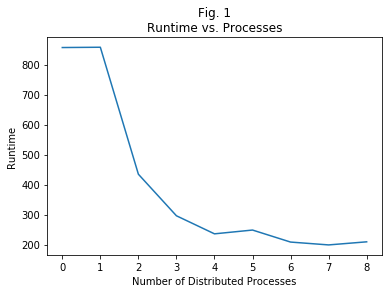

In [7]:
plt.figure(figsize = (6,4))
plt.plot(data)
plt.title("Fig. 1\nRuntime vs. Processes")
plt.ylabel("Runtime")
plt.xlabel("Number of Distributed Processes")
plt.savefig("processing")